本文以疾病筛查为例，介绍了如何用Python构建一个贝叶斯分层模型。

# 1. 医学筛查

有一项医学筛查技术，测试结果为假阳性的概率为0.15，假阴性率为0.1。在一次筛查中，随机对1,000人进行了检测，结果为阳性的有213人。该病在人群中发病率的后验分布是什么？

# 2. 概率模型

根据问题，假设
+ N=1000，参与测试人数；
+ p=213，阳性人数；
+ ${p}_{t}$，真阳性人数；
+ d，患病人数；
+ r，发病率。 

根据贝叶斯理论，我们有：

$$P(r | p) = {P(r) \centerdot P(p | r) \over \sum_{r \in R}P(r) \centerdot P(p | r)} \tag{1}$$

其中: 
+ $P(r)$为先验分布，我们可以简单假设其服从(0,1)区间上的均匀分布，即$R \sim U(0, 1)$；
+ $P(p|r)$为似然函数，已知发病率为$r$的情况下，测试结果为阳性人数$p$的分布。

后验分布$P(p|r)$是问题$(1)$的关键。知道$r$，并不能直接得到$p$的概率分布，检测结果有包括真阳性，也包括假阳性。如下表

 &ensp; | 阴性 | 阳性 
 :-: | :-: | :-: 
患病 |   -   |   ${p}_{t}$
未患病 | - | $$p-{p}_{t}$$   
合计 | $$N - p$$   | $p$

在患病率为$r$的情况下，计算测试结果为阳性的人数$p$的概率，还需要考虑“患有疾病测试结果为阳性的人数”和“没有患病但测试结果为阳性的人数”这两种情况。因此，需要在$r$与$p$的因果关系链中引入中间变量${p}_{t}、(p - {p}_{t})$作为桥梁，构建贝叶斯分层模型。

一般地，假设${y}_1, {y}_2, {y}_3, \dots$是互斥的随机事件，我们有如下计算随机变量边缘分布的方法：

$$\begin{align*}
P(x) & = P(x，y_1) + P(x，y_2) + \dots \\
     & = \sum_i P(x | y_i) \centerdot P(y_i)
\end{align*} \tag{2}$$

有了公式$(2)$，就可以用它来构建医学筛查的贝叶斯层次模型。根据前面的分析，引入中间变量${p}_{t}、(p - {p}_{t})$后，可得到一个3维的联合概率函数为：
$$\begin{align}
P(p，p_t，d \mid r, N)
\end{align}$$

运用$(2)$式中的方法，可以逐步得到$p$的边缘分布概率质量函数：

$$ \begin{align*} 
P(p, p_t \mid r, N) &= \sum_iP(p，p_t \mid d_i，r, N) \centerdot P(d_i \mid r，N) \\
P(p \mid r, N)  &= \sum_i \sum_j P(p \mid p_{t_j}, r, N) \centerdot P (p_{t_j} \mid d_i, r, N) \centerdot P(d_i \mid r, N) 
\tag{3}
\end{align*}
$$ 

$(3)$式右边的每一项都可以用二项分布来表示。其中，
+ 右边第一项$P(p | {p}_{{t}_{j}}, r, N)$表示有${p}_{t}$个真实阳性的情况下，测试结果为阳性的数量$p$的概率。即，当假阳性率为${r}_{fp}$时，从没有疾病的$N-d$个人中，得到$（p-{p}_{t}）$个假阳性的概率。
$$ (P-P_t) \sim B(p - {p}_{t} \mid N - d, {f}_{fp})  \tag{4}$$
+ 右边第二项$P({p}_{{t}_{j}} \mid {d}_{i}, r, N)$表示当受检人群中患病人数为$d$时，真实阳性为${p}_{t}$的概率。即，当对患病人群检测成功率为$1 - {r}_{fn}$时，在$d$个患病受检者中检测出${p}_{t}$个阳性的概率。
$$P_t \sim B({p}_{t} \mid d, 1 - {r}_{fn}) \tag{5}$$
+ 右边第三项$P(d_i \mid r, N)$表示当疾病发生率为$r$时，$N$个人中有$d$个患病的概率。
$$D \sim B(d_i \mid N, r) \tag{6}$$

# 3. 概率编程

综上，用Python进行贝叶斯概率编程的步骤如下。
+ 生成公式$(1)$中的先验分布$P(r)$;
+ 针对$r$的每一个值，根据公式$(3)$计算似然函数值；
+ 针对$r$的每一个值，用先验分布值乘以对应的似然函数值，该步的乘积与后验分布成正比；
+ 对第三步计算结果归一化处理。

下面是完整代码，其中最关键部分是似然函数Likelihood()。

In [1]:
from tools import Suite
from scipy.stats import binom  # 二项分布
from numpy import linspace     # 插值

class MedicalTest(Suite):
    """医学筛查的分层贝叶斯模型。"""
    
    def __init__(self, n=50, r_fn=0.15, r_fp=0.1,Name=None):
        """初始化。
        
        参数：
            setp,先验r在（0，1）区间上取值的步长；
            r_fn,假阴性占比
            r_fp,假阳性占比
        """
        self.r_fn = r_fn
        self.r_fp = r_fp
        # r的先验分布
        rs = linspace(0,1,n)
        Suite.__init__(self, rs, name=None)
    
    def Likelihood(self, data, hypo):
        """给定假设的似然函数。        

        data: 元组（N,p）,其中N为参与测试人数，p为测试结果为阳性人数。
        hypo: 先验分布概率值
        """
        N = data[0]
        p = data[1]
        r = hypo
        # 得病人数分布
        d_range = range(N + 1) 
        # 真阳性的人数分布
        p_t_range = range(p + 1)
        
        total = 0
        for d in d_range:   # 两个循环，对应(3)式中两次求和
            for p_t in p_t_range:   
                p1 = binom.pmf(p - p_t, N - d, self.r_fp)  # 概率分布(4)
                p2 = binom.pmf(p_t, d, (1 - self.r_fn))    # 概率分布(5)
                p3 = binom.pmf(d, N, r)                    # 概率分布(6)
           
                total += (p1 * p2 * p3)
   
        return total       

In [2]:
suite = MedicalTest()

计算后验分布。

In [3]:
suite.Update((1000,213))

0.0013053635160419918

作出后验分布图。

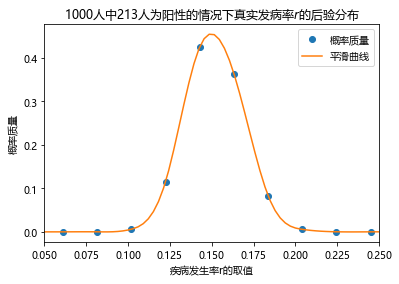

In [4]:
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

# 随机变量的取值列表和概率列表，作图用
x,y = zip(*suite.Items())
xs = linspace(0,0.3,100)
# 因计算时间太长，模型中r的点密度较为稀疏
# 计算出后验后，通过插值平滑后验分布图形
f2 = interp1d(x, y, kind='cubic')
# 作图
plt.plot(x,y,'o',xs,f2(xs),'-')
plt.legend(['概率质量', '平滑曲线'], loc='best')
plt.title('1000人中213人为阳性的情况下真实发病率$r$的后验分布')
plt.xlabel('疾病发生率r的取值')
plt.ylabel('概率质量')
plt.xlim(0.05,0.25)
plt.show()

本文中程序运行时间较长，如果有好的优化方法，请与我联系。完整源代码请到[GitHub](https://github.com/HuRongxing/thinkbayes)下载。
本文例子来自[博客Maximum Entropy](http://maximum-entropy-blog.blogspot.com/2015/10/multi-level-modeling.html "maximum-entropy-blog")，有修改。